In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from collections import OrderedDict
from matplotlib.ticker import PercentFormatter
import pickle
import pickle5
import math
from math import sin, cos, sqrt, atan2, radians

In [2]:
## block warning
import warnings
warnings.filterwarnings('ignore')

In [137]:
# under_utilization data
with open("../data/under_utilization_combinedStations.pkl", "rb") as fh:
    df = pickle5.load(fh)
    
df = df.reset_index(drop = True)
df.head()

,life_time,datetime,latitude,longitude,distance_center_km,Station_Name,weekday_b,weekday_b_name,hour_b,charging_ports
0,928.5,2018-01-31 19:51:00,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,2,Wednesday,19,2
1,363.5,2018-02-01 14:03:00,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,3,Thursday,14,2
2,6828.5,2018-02-01 21:15:00,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,3,Thursday,21,2
3,5871.5,2018-02-06 15:27:00,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,1,Tuesday,15,2
4,1454.5,2018-02-10 18:26:00,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,5,Saturday,18,2


In [138]:
# add end time
end_time = []
for i in range(0,len(df)):
    row = df.iloc[i]
    end_time.append(row.datetime + datetime.timedelta(seconds=row.life_time*60))

df.rename(columns={'datetime':'datetime_start'}, inplace=True)
df.insert(2,'datetime_end',end_time)

In [140]:
# charging data
with open("../data/Electric_Vehicle_Charging_Station_Energy_Consumption_cleaned.pkl", "rb") as fh:
    df_charging = pickle5.load(fh)
    
df_charging.head()

,Station_Name,Station_Address,City,State_Province,Postal_Code,Transaction_Date,Transaction_Start_Time,Charging_Time__minutes_,Energy__kWh_,GHG_Savings__kg_,...,Transaction_Date_Datetime,start_Datetime,end_Datetime,idle_time_minutes,latitude,longitude,weekday,weekday_name,distance_center_km,year
0,COMM VITALITY / 1104 SPRUCE1,1100 Spruce St,Boulder,Colorado,80302,2018/01/31 00:00:00+00,2021/01/21 17:43:00+00,128.0,2.84,1.19,...,2018-01-31 00:00:00+00:00,2018-01-31 17:43:00,2018-01-31 19:51:00,929.0,40.018482,-105.281066,2,Wednesday,0.152203,2018
1,COMM VITALITY / 1000WALNUT1,900 Walnut St,Boulder,Colorado,80302,2018/01/31 00:00:00+00,2021/01/21 17:16:00+00,68.0,5.66,2.38,...,2018-01-31 00:00:00+00:00,2018-01-31 17:16:00,2018-01-31 18:24:00,228.0,40.015994,-105.282473,2,Wednesday,0.378654,2018
2,BOULDER / REC CENTER ST2,1305-1335 Gillaspie Dr,Boulder,Colorado,80305,2018/01/31 00:00:00+00,2021/01/21 13:52:00+00,73.0,3.94,1.65,...,2018-01-31 00:00:00+00:00,2018-01-31 13:52:00,2018-01-31 15:05:00,2356.0,39.974881,-105.249219,2,Wednesday,5.638648,2018
3,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,2018/01/31 00:00:00+00,2021/01/21 13:54:00+00,40.0,4.42,1.86,...,2018-01-31 00:00:00+00:00,2018-01-31 13:54:00,2018-01-31 14:34:00,1259.0,40.000148,-105.282437,2,Wednesday,2.096847,2018
4,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,2018/01/31 00:00:00+00,2021/01/21 11:51:00+00,42.0,4.60,1.93,...,2018-01-31 00:00:00+00:00,2018-01-31 11:51:00,2018-01-31 12:33:00,81.0,40.000148,-105.282437,2,Wednesday,2.096847,2018


As we have combined some of the station names we need to take care of that also. We therefore need to add the new names to the `data` dataframe.

In [141]:
def name_trans(X):
    if (X == 'BOULDER / BOULDER PARK S1') or (X == 'BOULDER / BOULDER PARK S2'):
        return 'BOULDER / BOULDER PARK'
    if (X == 'BOULDER / REC CENTER ST2') or (X == 'BOULDER / REC CENTER ST1'):
        return 'BOULDER / REC CENTER'
    if (X == 'COMM VITALITY / 1000WALNUT1') or (X == 'COMM VITALITY / 1000WALNUT2'):
        return 'COMM VITALITY / 1000WALNUT'
    if (X == 'COMM VITALITY / 1500PEARL1') or (X == 'COMM VITALITY / 1500PEARL2'):
        return 'COMM VITALITY / 1500PEARL'
    else:
        return X

In [142]:
df_charging['new_Station_Name'] = df_charging['Station_Name'].apply(name_trans)

# Features

### Lags
Features for the last survival time, second last and third last for every observation.

In [144]:
names = df['Station_Name'].unique()

In [145]:
# initiate the lag columns
df['lag1'] = np.zeros(len(df))
df['lag2'] = np.zeros(len(df))
df['lag3'] = np.zeros(len(df))

In [146]:
temp = df[df['Station_Name'] == 'BOULDER / N BOULDER REC 1']
temp = temp.sort_values(by=['datetime_start']) # sort the values by the time
temp = temp.reset_index() # reset the index
temp = temp.rename(columns = {'index':'orig_index'}) # rename the original index column

In [147]:
for name in station_subset:
    # split df by station
    temp = df[df['Station_Name'] == name]
    temp = temp.sort_values(by=['datetime_start']) # sort the values by the time
    temp = temp.reset_index() # reset the index
    temp = temp.rename(columns = {'index':'orig_index'}) # rename the original index column
    
    for index, row in temp.iterrows(): # iterate over the station specific dataframe
        in1 = index-1
        in2 = index-2
        in3 = index-3
        if in1 < 0:
            df['lag1'].loc[row['orig_index']] = np.nan
        else:
            df['lag1'].loc[row['orig_index']] = temp['life_time'].iloc[in1]
        
        if in2 < 0:
            df['lag2'].loc[row['orig_index']] = np.nan
        else:
            df['lag2'].loc[row['orig_index']] = temp['life_time'].iloc[in2]
            
        if in3 < 0:
            df['lag3'].loc[row['orig_index']] = np.nan
        else:
            df['lag3'].loc[row['orig_index']] = temp['life_time'].iloc[in3]

### Activity within the last 1, 2 and 3 hours
Average charging time for K previous hours.

In [148]:
def charge_time(K, row, df_st): # takes charging data as input
    t1 = row.datetime_start - datetime.timedelta(hours=K)
    t2 = row.datetime_start
    
    # Events which are within the time interval
    temp_data = df_st[(df_st['start_Datetime'] >= t1) & (df_st['end_Datetime'] <= t2)]
    chargetime = temp_data.Charging_Time__minutes_.sum()
    
    # Events which cross into the time interval
    temp_data = df_st[(df_st['start_Datetime'] < t1) & (df_st['end_Datetime'] > t1)]
    for i in range(0,len(temp_data)):
        obj = (temp_data.iloc[i].end_Datetime-t1) # get time from t1 to the endtime of the event.
        chargetime += obj.days*24*60 #convert to minutes
        chargetime += obj.seconds/60 #convert to mintes
        
    return chargetime/(K*60)

Average energy usage for K previous hours.

In [149]:
def energy_usage(K, row, df_st): # takes charging data as input
    t1 = row.datetime_start - datetime.timedelta(hours=K)
    t2 = row.datetime_start
    
    # Events which are within the time interval
    temp_data = df_st[(df_st['start_Datetime'] >= t1) & (df_st['end_Datetime'] <= t2)]
    energyusage = temp_data.Energy__kWh_.sum()
    
    # Events which cross into the time interval
#     temp_data = df_st[(df_st['start_Datetime'] < t1) & (df_st['end_Datetime'] > t1)]
#     for i in range(0,len(temp_data)):
#         obj = (temp_data.iloc[i].end_Datetime-t1) # get time from t1 to the endtime of the event.
#         energyusage += obj.days*24*60 #convert to minutes
#         energyusage += obj.seconds/60 #convert to mintes
        
    return energyusage

The average amount of charging events every hour within the last K hours. Here only events which have a start and end time within the time interval.

In [150]:
def charge_events(K, row, df_st):
    t1 = row.datetime_start - datetime.timedelta(hours=K)
    t2 = row.datetime_start
    temp_data = df_st[(df_st['start_Datetime'] >= t1) & (df_st['end_Datetime'] <= t2)]
    return temp_data.shape[0]

The amount of inactivity (life-time) in minutes within the last K hours. Including events which goes into the time interval. 

In [151]:
def inactivity(K, row, df_st2):
    t1 = row.datetime_start - datetime.timedelta(hours=K)
    t2 = row.datetime_start
    
    # observations which are within the time interval
    temp_data = df_st2[(df_st2['datetime_start'] >= t1) & (df_st2['datetime_end'] <= t2)]
    inac = sum(temp_data.life_time)
    
    # Events which cross into the time interval
    temp_data = df_st2[(df_st2['datetime_start'] < t1) & (df_st2['datetime_end'] > t1)]
    for i in range(0,len(temp_data)):
        obj = (temp_data.iloc[i].datetime_end-t1) # get time from t1 to the endtime of the event.
        inac += obj.days*24*60 #convert to minutes
        inac += obj.seconds/60 #convert to mintes
        
    # return inac
    return inac/(K*60) # gives it in percentage of the total time available.

Construct the features for every hour, H1, H2 and H3.

In [152]:
## Create dictionary
dictt = {}

## the times before event
times = [1,2,3,4,5,6]#[3,6,9,12,15,18,21,24]
for x in times: ## add keys
    dictt['charge_time_'+str(x)+'H'] = []
    dictt['charge_energy_'+str(x)+'H'] = []
    dictt['inactivity_'+str(x)+'H'] = []
    dictt['charge_events_'+str(x)+'H'] = []
    
    
## Retreive data and save in dictionary
for i in range(0,len(df)):
    if i % 500 == 0:
        print(round(i/len(df)*100,2),"%", end=' ')
    row = df.iloc[i]
    df_st = df_charging[df_charging['new_Station_Name'] == row['Station_Name']]
    df_st2 = df[df['Station_Name'] == row['Station_Name']]

    for x in times:
        charge_time_obs = charge_time(x, row, df_st)
        energy_usage_obs = energy_usage(x, row, df_st)
        inactivity_obs = inactivity(x, row, df_st2)
        charge_events_obs = charge_events(x, row, df_st)
        dictt['charge_time_'+str(x)+'H'].append(charge_time_obs)
        dictt['charge_energy_'+str(x)+'H'].append(energy_usage_obs)
        dictt['inactivity_'+str(x)+'H'].append(inactivity_obs)
        dictt['charge_events_'+str(x)+'H'].append(charge_events_obs)
        
        
## Add columns to dataframe
for key in dictt.keys():
    df[key] = dictt[key]

0.0 % 3.93 % 7.87 % 11.8 % 15.73 % 19.67 % 23.6 % 27.54 % 31.47 % 35.4 % 39.34 % 43.27 % 47.2 % 51.14 % 55.07 % 59.0 % 62.94 % 66.87 % 70.8 % 74.74 % 78.67 % 82.61 % 86.54 % 90.47 % 94.41 % 98.34 % 

In [153]:
df.to_pickle("../data/under_utilization_combinedStations_laggedV5.pkl")

### Activity at nearest station

In [155]:
# under_utilization data
with open("../data/under_utilization_combinedStations_laggedV5.pkl", "rb") as fh:
    df = pickle5.load(fh)
df.head()

,life_time,datetime_start,datetime_end,latitude,longitude,distance_center_km,Station_Name,weekday_b,weekday_b_name,hour_b,...,inactivity_4H,charge_events_4H,charge_time_5H,charge_energy_5H,inactivity_5H,charge_events_5H,charge_time_6H,charge_energy_6H,inactivity_6H,charge_events_6H
0,928.5,2018-01-31 19:51:00,2018-02-01 11:19:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,2,Wednesday,19,...,0.000000,1,0.426667,2.84,0.000000,1,0.355556,2.84,0.000000,1
1,363.5,2018-02-01 14:03:00,2018-02-01 20:06:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,3,Thursday,14,...,0.318750,1,0.543333,7.19,0.455000,1,0.452778,7.19,0.545833,1
2,6828.5,2018-02-01 21:15:00,2018-02-06 15:03:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,3,Thursday,21,...,0.714583,1,0.226667,4.06,0.771667,1,0.188889,4.06,0.809722,1
3,5871.5,2018-02-06 15:27:00,2018-02-10 17:18:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,1,Tuesday,15,...,0.902083,1,0.076667,2.34,0.921667,1,0.063889,2.34,0.934722,1
4,1454.5,2018-02-10 18:26:00,2018-02-11 18:40:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,5,Saturday,18,...,0.718750,1,0.223333,3.55,0.775000,1,0.186111,3.55,0.812500,1


To begin with we are only interested in looking at the activity of the nearest station of every station. We there for need to establish this. We can create a dictionary which for every station key holds the other nearest station as the value. 

In [156]:
station_names = df['Station_Name'].unique() # get unique station names
# construct dictionary which contain the station name as well as the latitude and longitude
station_dict = {}
for name in station_names:
    station_dict[name] = {}
    station_dict[name]['lat'] = df[df['Station_Name'] == name].latitude.unique()[0]
    station_dict[name]['lon'] = df[df['Station_Name'] == name].longitude.unique()[0]

In [157]:
# approximate radius of earth in km
R = 6373.0

for name in station_names:
    distance = 1000 # intiate distance
    nearest_station = '' # initiate nearest station
    # get lat and lon of "main" station
    lat1 = radians(station_dict[name]['lat'])
    lon1 = radians(station_dict[name]['lon'])
    # loop over all other stations
    for name2 in station_names:
        if name2 != name: # if the station name is different
            # get lat and lon of "secondary" station
            lat2 = radians(station_dict[name2]['lat'])
            lon2 = radians(station_dict[name2]['lon'])
            # calculate distance
            dlon = lon2 - lon1
            dlat = lat2 - lat1
            a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
            c = 2 * atan2(sqrt(a), sqrt(1 - a))
            new_distance = R * c
            # if the new_distance is smaller we update the distance and the nearest_station
            if new_distance < distance:
                distance = new_distance
                nearest_station = name2
        
    station_dict[name]['nearest_station'] = nearest_station

In [158]:
## function which returns the nearest station
def nearest_stat(X):
    return station_dict[X]['nearest_station']

## add nearest station to every station
df['nearest_station'] = df['Station_Name'].apply(nearest_stat)

To find the activity of the nearest station within, for example, the last 3 hours we need to calculate the wanted features for the nearest station for every event in the dataframe. 

In [159]:
## Create dictionary
dictt = {}
## the times before event
times = [1,2,3,4,5,6] #[3,6,9,12,15,18,21,24]
for x in times: ## add keys
    dictt['near_charge_time_'+str(x)+'H'] = []
    dictt['near_charge_energy_'+str(x)+'H'] = []
    dictt['near_inactivity_'+str(x)+'H'] = []
    dictt['near_charge_events_'+str(x)+'H'] = []
    
## Retreive data and save in dictionary
for i in range(0,len(df)):
    if i % 500 == 0:
        print(round(i/len(df)*100,2),"%", end=' ')
    row = df.iloc[i]
    # get dataframes for nearest station
    df_st = df_charging[df_charging['new_Station_Name'] == row['nearest_station']] # charging data
    df_st2 = df[df['Station_Name'] == row['nearest_station']] # survival times
    
    # Find activity level within last three hours
    for x in times:
        charge_time_obs = charge_time(x, row, df_st)
        energy_usage_obs = energy_usage(x, row, df_st)
        inactivity_obs = inactivity(x, row, df_st2)
        charge_events_obs = charge_events(x, row, df_st)
        dictt['near_charge_time_'+str(x)+'H'].append(charge_time_obs)
        dictt['near_charge_energy_'+str(x)+'H'].append(energy_usage_obs)
        dictt['near_inactivity_'+str(x)+'H'].append(inactivity_obs)
        dictt['near_charge_events_'+str(x)+'H'].append(charge_events_obs)
        
        
## Add columns to dataframe
for key in dictt.keys():
    df[key] = dictt[key]

0.0 % 3.93 % 7.87 % 11.8 % 15.73 % 19.67 % 23.6 % 27.54 % 31.47 % 35.4 % 39.34 % 43.27 % 47.2 % 51.14 % 55.07 % 59.0 % 62.94 % 66.87 % 70.8 % 74.74 % 78.67 % 82.61 % 86.54 % 90.47 % 94.41 % 98.34 % 

In [160]:
df.to_pickle("../data/under_utilization_combinedStations_laggedV5.pkl")

In [2]:
# under_utilization data
with open("../data/under_utilization_combinedStations_laggedV5.pkl", "rb") as fh:
    df = pickle5.load(fh)

#### Correlations

In [3]:
station_subset = ['BOULDER / N BOULDER REC 1', 'COMM VITALITY / 1000WALNUT', 
                  'COMM VITALITY / 1104 SPRUCE1', 'BOULDER / BASELINE ST1']
df_sub = df[df['Station_Name'].isin(station_subset)]

In [4]:
inac = ['inactivity_1H','inactivity_2H','inactivity_3H',
        'inactivity_4H','inactivity_5H','inactivity_6H']
energy = ['charge_energy_1H','charge_energy_2H','charge_energy_3H',
          'charge_energy_4H','charge_energy_5H','charge_energy_6H']
charge = ['charge_time_1H','charge_time_2H','charge_time_3H',
          'charge_time_4H','charge_time_5H','charge_time_6H']
events = ['charge_events_1H','charge_events_2H','charge_events_3H',
          'charge_events_4H','charge_events_5H','charge_events_6H']

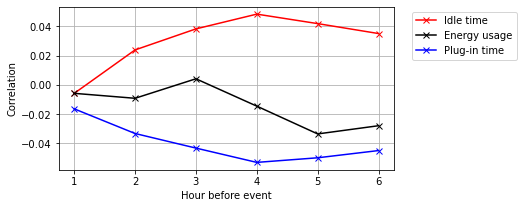

In [5]:
df_corr = df_sub
corrMatrix = df_corr.corr()
times = [1,2,3,4,5,6]#
temp = corrMatrix['life_time']
fig, ax = plt.subplots(figsize=(6,3))
plt.grid()
plt.plot(times,temp[inac], label='Idle time', c='r', marker='x')
plt.plot(times,temp[energy], label='Energy usage', c='k', marker='x')
plt.plot(times,temp[charge], label='Plug-in time', c='b', marker='x')
#plt.plot(times,temp[events], label='Events', c='k', marker='x')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax.set_xlabel("Hour before event")
ax.set_ylabel("Correlation")
#plt.xlim([0.9,6.1])
plt.savefig("../Thesis - writing/Visualization/correlation.pdf", bbox_inches='tight')
plt.show()

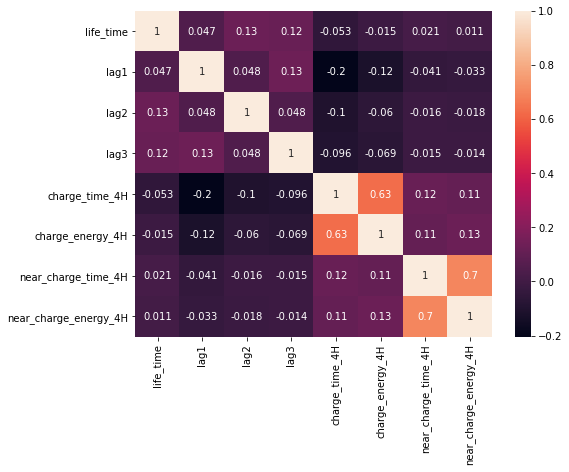

In [25]:
features = ['life_time',
       'lag1', 'lag2', 'lag3', 'charge_time_4H',
       'charge_energy_4H','near_charge_time_4H', 'near_charge_energy_4H']

df_corr = df_sub[features]
corrMatrix = df_corr.corr()
plt.rcParams['figure.figsize'] = (8,6)
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [35]:
import seaborn as sns

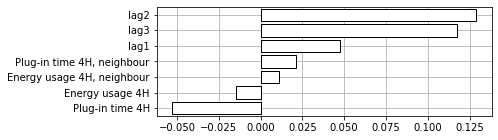

In [64]:
fig, axs = plt.subplots(figsize=(6,2))
labels = ['lag2','lag3','lag1','Plug-in time 4H, neighbour',
          'Energy usage 4H, neighbour','Energy usage 4H','Plug-in time 4H']
sns.barplot(y=labels, x=fea_corr.values, color='w', edgecolor='k')
plt.grid()
axs.set_axisbelow(True)
plt.savefig("../Visualization/correlation_bar.pdf", bbox_inches='tight')
plt.show()

Interesting to see that the `lag` features are the most correlated variables of which the event which is most resent has the largest correlation. Of the *activity* features within last 3 hours the `charge_energy_3H` has the highest positiv correlation (allthough very close to 0) while the `charge_events_3H`has the highest negativ correlation (larger then the postive but still less than -0.1). 